<center>
<h1>236606 - Machine Learning and Human Behavior</h1>
<h2>Workshop #1 - Binary Choice ⚖️</h2>
</center>

IDs:
* 302919402
*204030720

# Introduction

In our setting, users make a binary decision of whether or not to consume an item. Each item is represented by a vector $x\in\mathbb{R}^n$, and the outcome is represented using binary variable $y\in\left\{-1,1\right\}$, such that $y=1$ when the item was consumed. 

For the implementation of behavioral bias models, we define the following abstract class:

In [ ]:
import abc

class UserModel(abc.ABC):
  @abc.abstractclassmethod
  def __call__(self, X, *args):
    '''
    Given items X, calculate the user's valuation v(x) for each item x
    '''
    raise NotImplementedError()
  
  def predict(self, X, *args):
    '''
    Given items X, calculate the user's preference (-1/1) for each item x
    '''
    raise NotImplementedError()


class PopulationModel(abc.ABC):
  @abc.abstractclassmethod
  def __call__(self, X, *args):
    '''
    Given items X, calculate each user's valuation v(x) for each item x
    '''
    raise NotImplementedError()
  
  def predict(self, X, *args):
    '''
    Given items X, calculate each user's preference y for each item x
    '''
    raise NotImplementedError()


## **A simple example**

**Create a user model**

The following class defines a linear valuation model with additive decision noise - The perceived utility of each item is modeled as a linear function of the feature vector `X`, with additive normal noise.

In [ ]:
import numpy as np

VEC_STD = 10
class NoiseUserModel(UserModel):
  """
  v(x) = u*x + noise
  for a randomly generated u vector
  """

  def __init__(self, num_features):
    self.num_features = num_features
    self.utility_vec = np.random.randn(num_features)*VEC_STD

  def __call__(self, X, noise_std):
    noise = noise_std * np.random.randn(X.shape[0])
    return X@self.utility_vec + noise
  
  def predict(self, X, noise_std):
    return np.sign(self(X, noise_std))

**Create a population model**

The following class defines a population of users, where the choice model of each user is the `NoiseUserModel` defined above.

In [ ]:
class NoisePopulationModel(PopulationModel):
  """
  aggregates a population of users into a population model 
  """

  def __init__(self, num_users, num_features):
    self.user_models = [NoiseUserModel(num_features) for i in range(num_users)]

  def __call__(self, X, noise_std):
    """
    returns a matrix of size (number of items X number of uesrs)
    """
    return np.array([m(X, noise_std) for m in self.user_models]).T
  
  def predict(self, X, noise_std):
    return np.sign(self(X, noise_std))

# Utility functions

The utilty functions defined below will be used throughout this notebook. They will be useful for generating data, training models, and evaluating results.

**Load dataset**

In [ ]:
def generate_synth_data(num_features, num_items):
  """
  Generates a random dataset of items of size (num_items X num_features)
  """
  items = np.random.randn(num_items, num_features)
  return items

Example:

In [ ]:
num_features = 3
num_items = 100
num_users = 10

# Create a population model
population_model = NoisePopulationModel(num_users, num_features)

# Generate items
X = generate_synth_data(num_features, num_items)
args = {"noise_std":0.5}

# calculate users preferences according to the model
y = population_model.predict(X, **args)

**Create a training pipeline**

The following class defines a training pipeline for a given model and population model. Pipeline stages, as defined by the `__call__` function: 
1. Simulate binary choice using the given choice model
2. Randomly split the dataset to train and test sets
3. Fit the given model (model is an argument of the pipeline constructor)
4. Evaluate model fit (metrics are given as arguments of the pipeline constructor)

In [ ]:
from sklearn.model_selection import train_test_split

class TrainingPipeline():
  def __init__(self, training_model, metrics, test_size=0.33,
               seed=0):
    """
    training_model: a scikit training model
    metrics: a dictionary of metric functions (values) and their names (keys).
    each one takes (training_model, population_model, model_args, X) as arguments.
    """
    self.training_model = training_model
    self.metrics = metrics
    self.test_size = test_size
    self.seed = seed

  # Splits the data into train and test sets
  def split(self, X, y):
    return train_test_split(X, y, test_size=self.test_size, random_state=self.seed)

  # train the model on the train dataset
  def fit(self, X_train, y_train):
    self.training_model.fit(X_train, y_train)

  # activate each metric on the the test set
  def evaluate(self, population_model, model_args, X_test):
    if model_args is None:
      model_args = {}
    return {name : metric(self.training_model, population_model, model_args, X_test) for name, metric in
            metrics.items()}

  # Split, fit and evaluate
  def __call__(self, X, population_model, model_args=None):
    """
    Calls split, then trains the model and then evaluates it according to each metric 
    """
    if model_args is None:
      model_args = {}
    y = population_model.predict(X, **model_args)
    X_train, X_test, y_train, y_test = self.split(X, y)
    self.fit(X_train, y_train)
    return self.evaluate(population_model, model_args, X_test)

**Define some evaluation metrics**

In [ ]:
from sklearn.metrics import accuracy_score

# calculates the accuracy of the training_model
def accuracy(training_model, population_model, model_args, X):
  true_valuations = population_model(X, **model_args)
  pred_valuations = training_model.predict(X)

  return accuracy_score(np.sign(true_valuations).flatten(),
                        np.sign(pred_valuations).flatten())

**Train!**

Example:

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Create linear regression object
training_model = LinearRegression()

# Create metrics list
metrics = {"accuracy" : accuracy}

# Create pipeline
t = TrainingPipeline(training_model, metrics)

# Train and evaluate
args = {"noise_std": 0.5}
results = t(X, population_model, args)
results

{'accuracy': 0.9393939393939394}

# Task \#1: Quantify cost of revealed preferences VS stated preferences


In this section we will examine and compare predictions in two scenarios: 
1. Users state their full preferenecs, i.e., give the learner access to their value function $v$.
2. Users only *reveal* their preferences through choice behavior, $y$.


Exercise:

We will start by comparing the performance of a choice model representing *stated preferences* to a model which represents *revealed preferences*, for varying levels of decision noise magnitude.

1. On the same figure, plot two line graphs representing the accuracy of a linear regression model, for variable decision noise standard deviation (`std`) in the range [1,10], on the given items set and population model. 

  Plot one line graph for *stated preferences*, and another line for *revealed preferences*, according to the following definitions:

  * Stated preferences - calculate $sign(v(x))$ for each item in the test set. These will be the predictions of our model. Then, for each value of `std`, generate the true labels according to the population model with that `std`, and evaluate the accuracy.

  * Revealed preferences - for each value of `std` generate users labels for the items according to that value of `std`. Train on a train set and evaluate on a test set.
  
  Hint: don't invent the wheel - you cane use `TrainingPipeline`.

In [ ]:
num_features = 3
num_items = 100
num_users = 10

# Create a  model
population_model = NoisePopulationModel(num_users, num_features)

# Generate items
X = generate_synth_data(num_features, num_items)

Text(0.5, 1.0, 'Mean accuracy as a function of Noise_std')

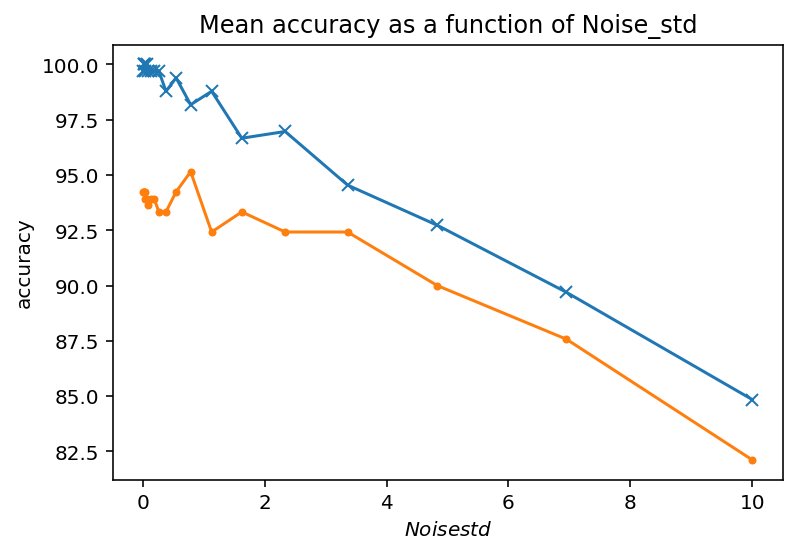

In [ ]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

std_vec = np.geomspace(0.01, 10, 20)

X_train, X_test, y_train, y_test = t.split(X, population_model.predict(X, 0)) # test set for stated preferences

stated_acc = []
revealed_acc = []
for std in std_vec:
  y_noised = population_model.predict(X_test, std)
  acc = np.sum(y_test == y_noised) / np.prod(y_noised.shape)
  stated_acc.append(100. * acc)

  acc = t(X, population_model, model_args={"noise_std": std})["accuracy"]
  revealed_acc.append(100. * acc)

# Train and evaluate

fig,ax = plt.subplots()
ax.plot(
    std_vec,
    stated_acc,
    'x-'
)
ax.plot(
    std_vec,
    revealed_acc,
    '.-'
)
ax.set_xlabel(r'$Noise std$')
ax.set_ylabel('accuracy')
ax.set_title(r'Mean accuracy as a function of Noise_std')

Plot a similar graph for each of the other metrics you created in HW1:
1. welfare (=expected utility)
2. MSE

Looking at all three measures, try to vary the parameters of the experiment (\#users, \#items, \#features, etc.) in ways that show interesting trends.

In [ ]:
def welfare(training_model, population_model, model_args, X):
  U = len(population_model.user_models)
  f = training_model.predict(X)
  sign = np.sign(f)
  I = (sign == 1).astype(np.int)
  v = population_model(X, **model_args)
  welfare = np.sum(I * v) / U
  return welfare


def MSE(training_model, population_model, model_args, X):
  U = len(population_model.user_models)
  M = X.shape[0]
  f = training_model.predict(X)
  v = population_model(X, **model_args)
  MSE = np.sum((f - v) ** 2) / (U * M)
  return MSE

Text(0.5, 1.0, 'Revealed welfare/MSE as a function of Noise_std')

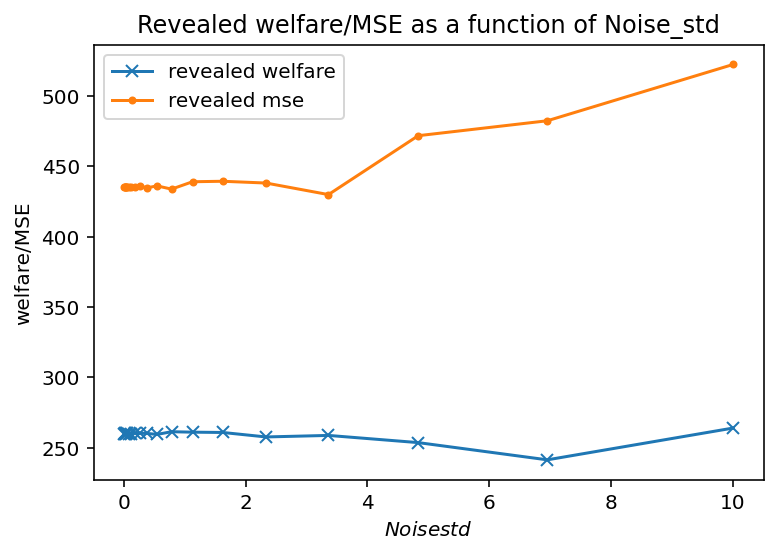

In [ ]:
# Create linear regression object
training_model = LinearRegression()

revealed_welfare = []
revealed_mse = []

for std in std_vec:

  training_model.fit(X_train, y_train)

  w = welfare(training_model, population_model, {"noise_std": std}, X_test)
  revealed_welfare.append(w)

  mse = MSE(training_model, population_model, {"noise_std": std}, X_test)
  revealed_mse.append(mse)


fig,ax = plt.subplots()
ax.plot(
    std_vec,
    revealed_welfare,
    'x-', 
    label="revealed welfare"
)
ax.plot(
    std_vec,
    revealed_mse,
    '.-',
    label="revealed mse"
)
ax.legend()
ax.set_xlabel(r'$Noise std$')
ax.set_ylabel('welfare/MSE')
ax.set_title(r'Revealed welfare/MSE as a function of Noise_std')

3. What did you observe? Explain your results here:

```
Answer: The welfare is the measure of expected utility, thus it remains ~fixed when increasing the noise std, since the noise has 0 expectation, hence adding it does not change the expected utility. However, when we increase the noise std, our model's prediction also has more variance, directly resulting in larger MSE.
Adding to that, the welfare optimization objective is not high accuracy, thus it is not affected by adding noise; even bad predictive models can have similar/high welfare.
```

4. **Assuming we use a linear classifer $y = \mathrm{sign}(w^Tx + b)$**, describe a simple dataset (can be 2D) for which the classifier yielding the best accuracy does *not* give optimal welfare. Explain your answer.

  Note: The following website may be useful for plotting a 2D dataset: https://app.diagrams.net/
  
  What do you observe? Explain your results here, and attach a clear illustration of the dataset:
  
```
The accuracy of a classifier does not necessarily indicate optimal welfare. 
Accuracy measures how many predictions of consumed or not items were correct, while welfare indicates the mean utility of items that were predicted as consumed by the classifier. 
Referring to the attached example, and assuming the value `v` of all samples is 1.
An optimal classifier (dotted blue line) predicts correctly for all the examples, achieving 100% accuracy but only 2 welfare, while a poor classifier (orange dotted line) predicts correctly only for half of the examples, having 50% accuracy, achieves 4 welfare!
```
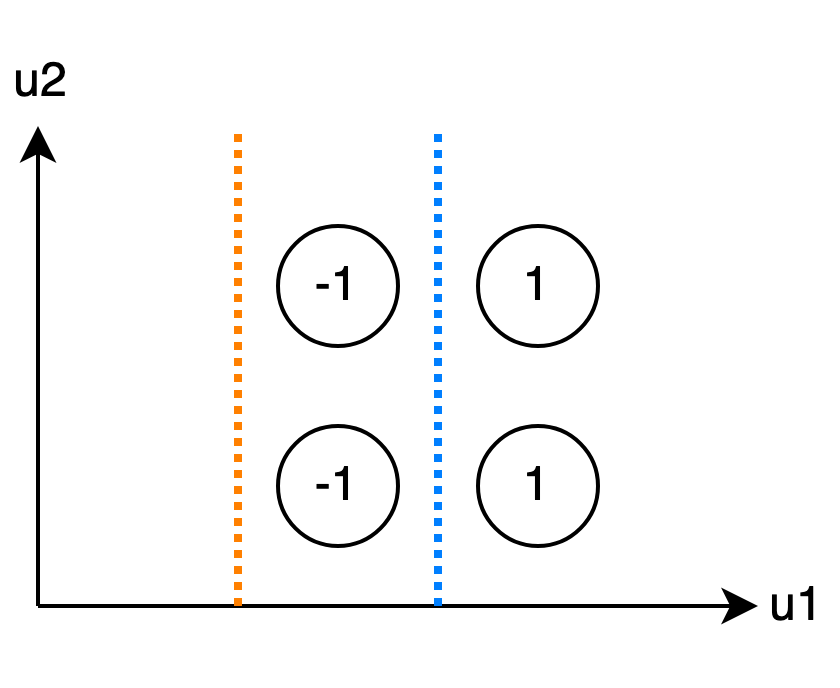


# Task \#2: Measuring the effects of implicitly assuming rational choice on behavioral data

In this exercise, we will evaluate the performance of a standard ("rational") prediction model when decision-makers are subject to behavioral biases. 

In this section, users make decisions under uncertainty. Each user has two inherent utility functions, $u_a$ and $u_b$, and a probability parameter $p\in\left[0,1\right]$. The user's utility from consuming an item $x$ is:
- $u_a(x)\in\mathbb{R}$ with probability $p$, and 
- $u_b(x)\in\mathbb{R}$ with probability $(1-p)$. 

When user behavior is *rational*, the decision is made by comparing the *expected utility* of the two alternatives:

$$
y_\text{rational}=\begin{cases}
1&p \cdot u_a(x) + (1-p) \cdot u_b(x) \ge 0\\
0&\text{otherwise}
\end{cases}
$$

When user decisions are subject to *behavioral bias*, choice deviates from the expected optiumum. In particular, we will focus on a setting where the users are *loss-averse*. In the spirit of Prospect Theory [[1](https://en.wikipedia.org/wiki/Prospect_theory)], we assume there exist two functions $\pi, v$ such that the perceived value from consuming the item is:

$$
\begin{align}
V_{\pi, v}\left(x\right)
&=\sum_{i=1}^n \pi\left(p_i\right) v\left(u_i(x)\right)\\
&=\pi(p) \cdot v(u_a(x)) + \pi(1-p) \cdot v(u_b(x))
\end{align}
$$

The function $v$ captures the loss-aversion property, and it is s-shaped and asymmetrical. The function $\pi$ is a probability weighting function and captures the idea that people tend to overreact to small probability events, but underreact to large probabilities. Assuming $v(0)=0$, consumption decisions are made according to the following rule:

$$
y_\text{prospect}=\begin{cases}
1&V_{\pi,v}(x) \ge 0\\
0&\text{otherwise}
\end{cases}
$$

## Implementation

For the implementation of this behavioral model, we define the following abstract classes: 

In [ ]:
class ProspectTheoryProbabilityWeighting(abc.ABC):
  @abc.abstractclassmethod
  def __call__(self, p):
    '''
    Calculate pi(p_k) for each p_k in p
    p is a one-dimensional numpy array
    '''
    raise NotImplementedError()


class ProspectTheoryLossAversion(abc.ABC):
  @abc.abstractclassmethod
  def __call__(self, p):
    '''
    Calculate v(u_k) for each u_k in u
    u is a one-dimensional numpy array
    '''
    raise NotImplementedError()

We can inherit from these classes to create specific behavioral models. For example, here are instances which model unbiased decision making:



In [ ]:
class NeutralProbabilityWeighting(ProspectTheoryProbabilityWeighting):
  def __call__(self, p):
    return p

class NeutralLossAversion(ProspectTheoryLossAversion):
  def __call__(self, u):
    return u

1. Implement a behavioral user model corresponding to prospect theory.
As in the noise user model, for each user generate two random vectors - one for each utility function, $u_a$ and $u_b$ (use std=$10$). Generate the probability $p$ uniformly in $[0, 1]$.

In [ ]:
STD_VEC = 10
class ProspectTheoryUserModel(UserModel):
  def __init__(self, num_features):
    self.num_features = num_features
    self.u_a = np.random.randn(num_features)*VEC_STD
    self.u_b = np.random.randn(num_features)*VEC_STD
    self.p = np.random.uniform(low=0, high=1, size=(1,))[0]

  def __call__(self, X, pi, v):
    v_a = v(X @ self.u_a)
    v_b = v(X @ self.u_b)

    p_a = pi(self.p)
    p_b = pi(1 - self.p)

    return p_a * v_a + p_b * v_b

  def predict(self, X, pi, v):
    np.sign(self(X, pi, v))

2. Implement a population model of prospect-theory users.

In [ ]:
class ProspectTheoryPopulationModel(PopulationModel):
  def __init__(self, num_users, num_features):
    self.user_models = [ProspectTheoryUserModel(num_features) for i in range(num_users)]

  def __call__(self, X, pi, v):
    """
    returns a matrix of size (number of items X number of uesrs)
    """
    return np.array([m(X, pi, v) for m in self.user_models]).T
  
  def predict(self, X, pi, v):
    return np.sign(self(X, pi, v))

## Understanding the functional form of $v$



The user valuation bias can be modeled using an S-shaped assymetrical function $v:\mathbb{R}\to\mathbb{R}$. Following [[2](https://www.econstor.eu/bitstream/10419/87132/1/472515071.pdf)], we assume that $v$ is a power S-shaped utility function, and its functional form is given by:


$$
v(u)=\begin{cases}
u^\alpha& u \ge 0 \\
-\gamma \left(-u\right)^\beta& u < 0
\end{cases}
$$

with constants $0< \alpha \le \beta \le 1$, and $\gamma\ge 1$.

3. Implement the class `PowerLossAversion`. The class constructor will receive three scalar constants `alpha`, `beta`, `gamma`.  The `__call__` function will calculate $v(u)$ as defined above:

In [ ]:
class PowerLossAversion(ProspectTheoryLossAversion):
  """
  The power S-shaped utility function, as defined by Maggi (2014)
  """
  def __init__(self, alpha, beta, gamma):
    assert 0 < alpha <= beta <= 1
    assert gamma >= 1
    self.alpha = alpha
    self.beta = beta
    self.gamma = gamma
  
  def __call__(self, u):
    u_pos_mask = (u >= 0).astype(np.int)
    u_neg_mask = (u < 0).astype(np.int)

    u_pos = (u * u_pos_mask) ** self.alpha
    u_neg = -self.gamma * ((-u * u_neg_mask) ** self.beta)

    return u_pos * u_pos_mask + u_neg * u_neg_mask

4. Using the implementation above, plot the function $\nu$ for values of $u$ in the range $[-2,2]$, and for the given sets of parameters:

  1. $\left(\alpha_1, \beta_1, \gamma_1\right) = \left(1, 1, 1\right)$
  2. $\left(\alpha_2, \beta_2, \gamma_2\right) = \left(1, 1, 2.5\right)$
  3. $\left(\alpha_3, \beta_3, \gamma_3\right) = \left(0.88, 0.88, 2.5\right)$
  4. $\left(\alpha_4, \beta_4, \gamma_4\right) = \left(0.2, 0.88, 1.8\right)$


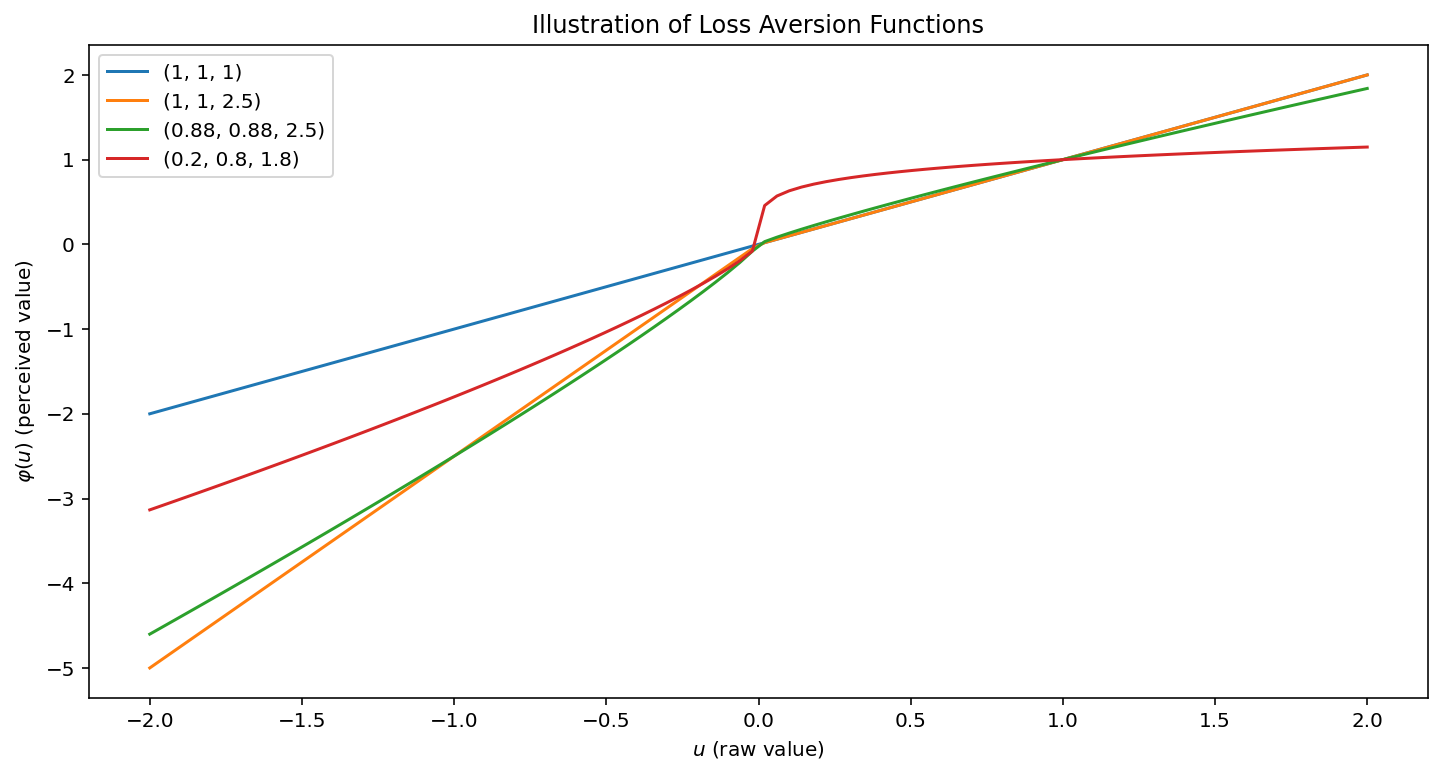

In [ ]:
params_lst = [
    (1,1,1),
    (1,1,2.5),
    (0.88,0.88,2.5),
    (0.2,0.8,1.8),
    # (0.2,0.2,1.8),
    # (0.2,0.2,2.5),
]

fig,ax = plt.subplots(figsize=(12,6))

u_vec = np.linspace(-2,2,100)
for alpha, beta, gamma in params_lst:
  v = PowerLossAversion(alpha, beta, gamma)
  ax.plot(u_vec, v(u_vec), label=str((alpha, beta, gamma)))

ax.set_title('Illustration of Loss Aversion Functions')
ax.set_xlabel('$u$ (raw value)')
ax.set_ylabel(r'$\varphi(u)$ (perceived value)')
ax.legend()


Given the results - 
1. What behavior is given by the curve parametrized by $\left(\alpha, \beta, \gamma\right) = \left(1, 1, 1\right)$?

```
Linear, unbaised monothonic raising function (f(x) = x)
```

2. What is the meaning of the parameter $\gamma$? What aspect of prospect theory does it correspond to?

```
the gamma corresponds to the `loss-aversioness` aspect of the model: as it gets higher, the user is more loss-averse (higher slope in the negative regime).
```

3. What is the meaning of the parameters $\alpha,\beta$? What aspects of prospect theory do they correspond to?

```
Those parameters determine how `s` will the function be in each regime (alpha for positive values, beta for negative), where the lower alpha and beta are, the more diminishing are the returns. 
```


## Predicting under behavioral bias



For each set of behavioral parameters $\left(\alpha_1, \beta_1, \gamma_1\right),\dots,\left(\alpha_4, \beta_4, \gamma_4\right)$ given above, and for a neutral probability weighting ($\pi(p)=p$), train and evaluate a *logistic regression model* on data generated by the given population model and items set.

In [ ]:
num_features = 3
num_items = 5000
num_users = 10

population_model = ProspectTheoryPopulationModel(num_users, num_features)
X = generate_synth_data(num_features, num_items)

In [ ]:
# Answer:
training_model = MultiOutputClassifier(LogisticRegression())
metrics = {"accuracy" : accuracy}
t = TrainingPipeline(training_model, metrics)

# Train and evaluate
identity_pi = NeutralProbabilityWeighting()

accuracies = {
    params: t(X, population_model, model_args={"pi": identity_pi, "v": PowerLossAversion(*params)}) for params in params_lst
}
accuracies

{(0.2, 0.8, 1.8): {'accuracy': 0.9270909090909091},
 (0.88, 0.88, 2.5): {'accuracy': 0.9749696969696969},
 (1, 1, 1): {'accuracy': 0.9971515151515151},
 (1, 1, 2.5): {'accuracy': 0.9755757575757575}}

Explain the results:

```
The model best fits the linear line where alpha=beta=gamma=1 (purly retional data model), which makes sense, since logistic regression opts for the linear separation hence fits this line almost perfectly. for other combinations, the model does not perform as well as for the triplet (1,1,1), but is still able to achieve reasonable results. We obtain that for (0.88,0.88,2.5) and (1,1,2.5) we get similar accuracies, concluding that gamma affects the model's ability to produce accurate results (since only alpha,beta vary, and gamma remained fixed). Furthermore, when |alpha - beta| >> 0, the shape of the `s` curve is less and less symetric, resulting in more irrational data model, leading to less accurate predictions. When alpha and beta are close to 1., the model is more linear, and predictions are better.
```

Plot a line graph representing the accuracy, for fixed $\alpha=\beta=1$ and variable $\gamma\in[1,15]$.

Text(0.5, 1.0, 'Mean accuracy as a function of $\\gamma$')

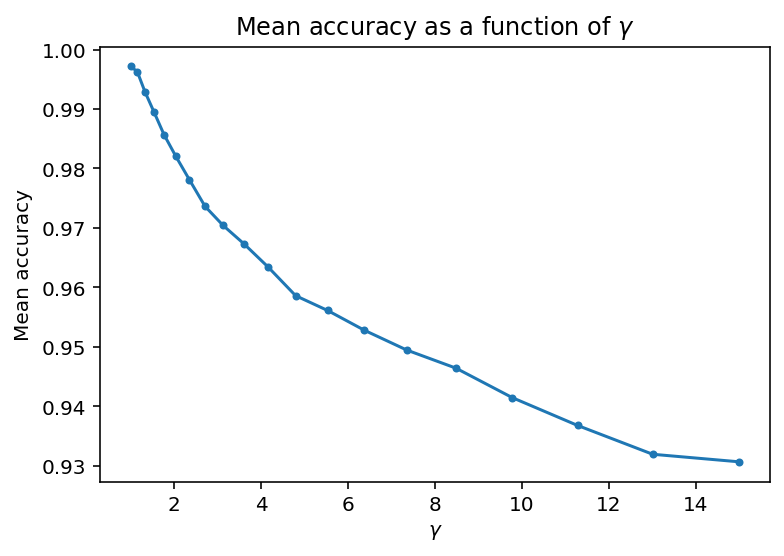

In [ ]:
# Answer:
gamma_vec = np.geomspace(1, 15, 20)
accuracies = [t(X, population_model, model_args={"pi": identity_pi, "v": PowerLossAversion(1, 1, gamma)})["accuracy"] for gamma in gamma_vec]

fig,ax = plt.subplots()
ax.plot(
    gamma_vec, accuracies, '.-'
)
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('Mean accuracy')
ax.set_title(r'Mean accuracy as a function of $\gamma$')

Explain the results:

```
We observe that increasing gamma reduces the predictive model's accuracy, i.e: the more loss-averse the data model is, the less accurate are the predictive model.
```

Similarly, plot a line graph representing the accuracy, for fixed $\gamma=10$ and variable $\alpha=\beta\in(0,1]$. 


Text(0.5, 1.0, 'Mean accuracy as a function of $\\alpha=\\beta$')

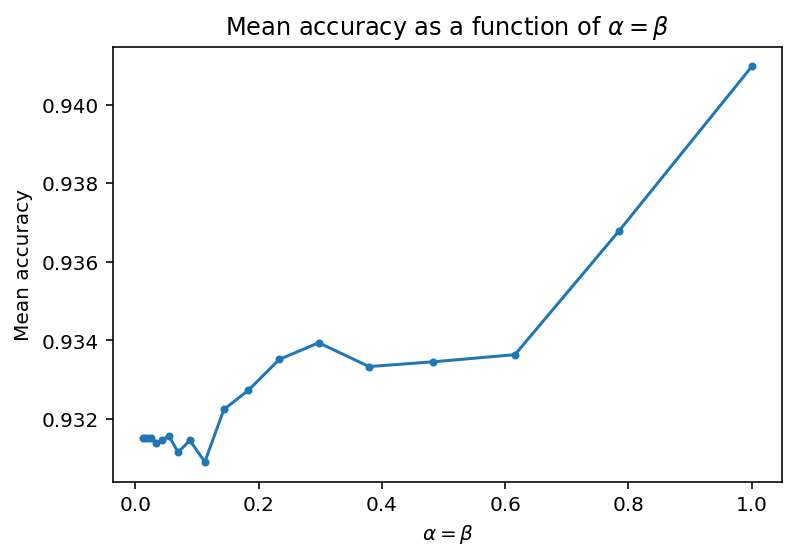

In [ ]:
alphabeta_vec = np.geomspace(0.01,1,20)[1:]
accuracies = [t(X, population_model, model_args={"pi": identity_pi, "v": PowerLossAversion(alphabeta, alphabeta, 10)})["accuracy"] for alphabeta in alphabeta_vec]

fig,ax = plt.subplots()
ax.plot(
    alphabeta_vec, accuracies, '.-'
)
ax.set_xlabel(r'$\alpha=\beta$')
ax.set_ylabel('Mean accuracy')
ax.set_title(r'Mean accuracy as a function of $\alpha=\beta$')

Repeat the experiment above but with $\gamma=1$:

(plot a line graph representing the accuracy, for fixed $\gamma=1$ and variable $\alpha=\beta\in(0,1]$)


Text(0.5, 1.0, 'Mean accuracy as a function of $\\alpha=\\beta$')

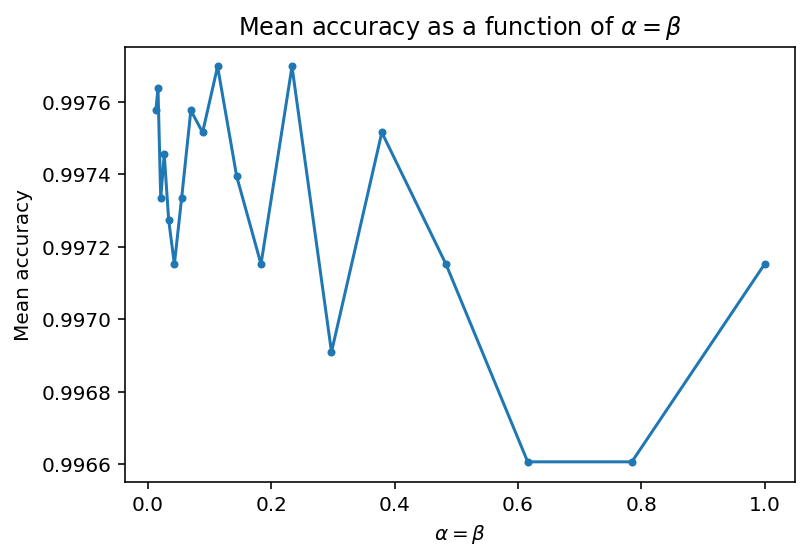

In [ ]:
alphabeta_vec = np.geomspace(0.01,1,20)[1:]
accuracies = [t(X, population_model, model_args={"pi": identity_pi, "v": PowerLossAversion(alphabeta, alphabeta, 1)})["accuracy"] for alphabeta in alphabeta_vec]

fig,ax = plt.subplots()
ax.plot(
    alphabeta_vec, accuracies, '.-'
)
ax.set_xlabel(r'$\alpha=\beta$')
ax.set_ylabel('Mean accuracy')
ax.set_title(r'Mean accuracy as a function of $\alpha=\beta$')

Explain the results:

```
Higher gamma values impact the predictive model's accuracy more than varying alpha and beta. When alpha=beta=0, we get a step function, and the more alpha and beta approach towards 1, the function is becoming closer to a piece-wise linear function. Given a fixed gamma, modifying alpha and beta from ~0 to 1 improves accuracy (data is more linear), but the effect is not as significant as gamma has.
```

What can we conclude about the performance of a logistic regression classifier on behavioral data? What can explain the above observations?

```
When data is rational, Logistic regression performs very well, achieving high accuracy. However, when data becomes less rational, for example highly loss-averse users, the accuracy of the predictive model drops.
```



## Bonus: Alternative probability weighting

Up until now, the decision model we analyzed assumed $\pi$ to be neutral ($\pi(p)=p$). A model with the following $\pi$ is proposed:

$$\pi(p)=(1-p)\cdot\sqrt{p}+p\cdot(1-\sqrt{1-p})
$$
Will this change the accuracy analysis results? If so, how and in which direction? If not, why? Explain.

Design and run appropriate experiment(s) - show plots that support your claim.

```
We argue that it will merely affect the result, specifically will not change the trends we observed. The performance of the predictive models highly depends on the data model, and less on the function pi. The pi function only weights the different v functions with different utilities. For each user, once the probability p is drawn, pi simply plays the role of scaling it deterministically, thus will have less effect on the predictive model. We provide the following experiments to support our claim:
```

In [ ]:
class NonNeutralProbabilityWeighting(ProspectTheoryProbabilityWeighting):
  def __call__(self, p):
    return (1 - p) * np.sqrt(p) + p * (1 - np.sqrt(1 - p))

non_natural_pi = NonNeutralProbabilityWeighting()

Text(0.5, 1.0, 'Mean accuracy as a function of $\\gamma$')

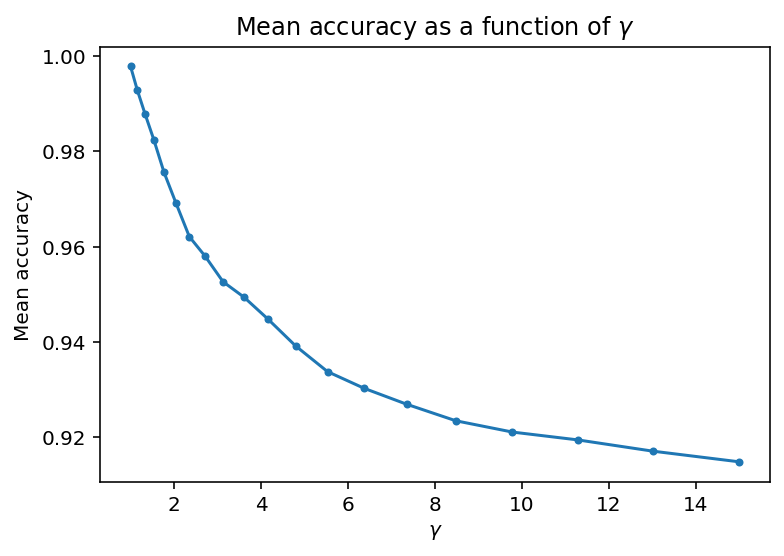

In [ ]:
gamma_vec = np.geomspace(1, 15, 20)
accuracies = [t(X, population_model, model_args={"pi": non_natural_pi, "v": PowerLossAversion(1, 1, gamma)})["accuracy"] for gamma in gamma_vec]

fig,ax = plt.subplots()
ax.plot(
    gamma_vec, accuracies, '.-'
)
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('Mean accuracy')
ax.set_title(r'Mean accuracy as a function of $\gamma$')

Text(0.5, 1.0, 'Mean accuracy as a function of $\\alpha=\\beta$')

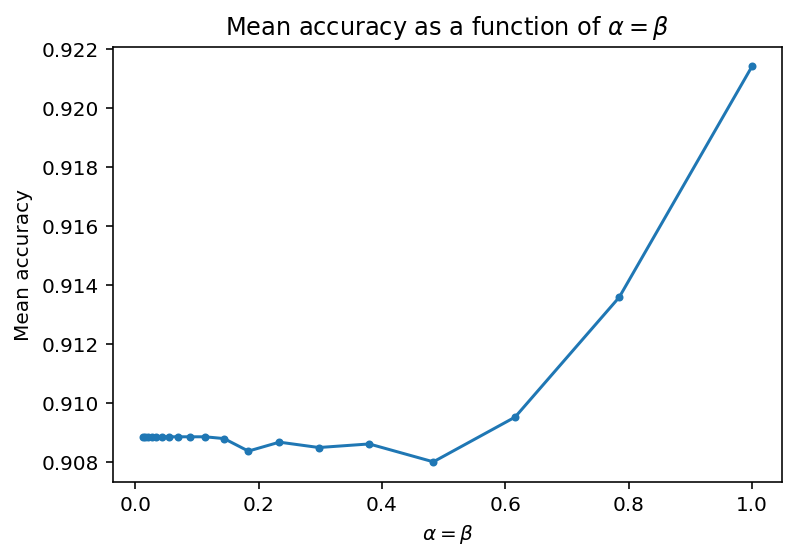

In [ ]:
alphabeta_vec = np.geomspace(0.01,1,20)[1:]
accuracies = [t(X, population_model, model_args={"pi": non_natural_pi, "v": PowerLossAversion(alphabeta, alphabeta, 10)})["accuracy"] for alphabeta in alphabeta_vec]

fig,ax = plt.subplots()
ax.plot(
    alphabeta_vec, accuracies, '.-'
)
ax.set_xlabel(r'$\alpha=\beta$')
ax.set_ylabel('Mean accuracy')
ax.set_title(r'Mean accuracy as a function of $\alpha=\beta$')

Text(0.5, 1.0, 'Mean accuracy as a function of $\\alpha=\\beta$')

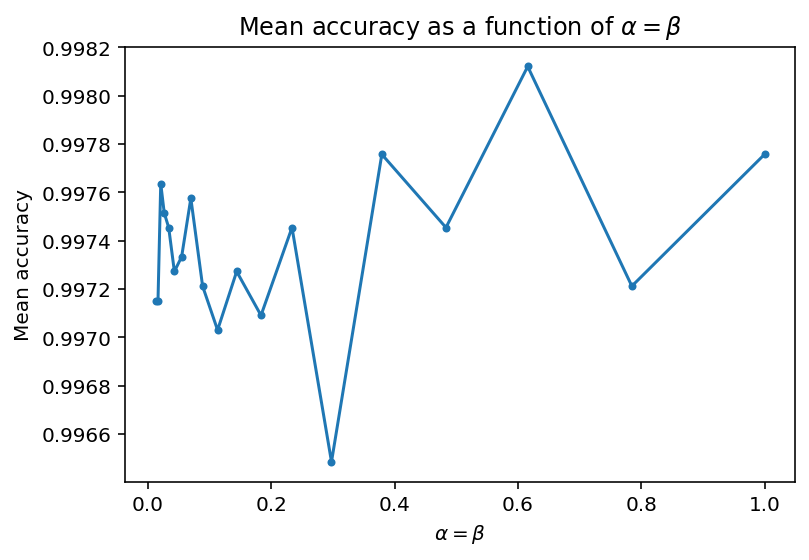

In [ ]:
alphabeta_vec = np.geomspace(0.01,1,20)[1:]
accuracies = [t(X, population_model, model_args={"pi": non_natural_pi, "v": PowerLossAversion(alphabeta, alphabeta, 1)})["accuracy"] for alphabeta in alphabeta_vec]

fig,ax = plt.subplots()
ax.plot(
    alphabeta_vec, accuracies, '.-'
)
ax.set_xlabel(r'$\alpha=\beta$')
ax.set_ylabel('Mean accuracy')
ax.set_title(r'Mean accuracy as a function of $\alpha=\beta$')

# Task \#3: Accounting for behavioral deviations 

In this part, we will attempt to account for behavioral deviations using different methods.

This task is exploratory, and we encourage you to try different and creative approaches to solve it.

First, we load a real world dataset of items representing different smartphone models, described by various features.

In [ ]:
!git init
!git pull "https://github.com/SagiLevanon1/WS1.git"

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 50 (delta 16), reused 45 (delta 11), pack-reused 0
Unpacking objects: 100% (50/50), done.
From https://github.com/SagiLevanon1/WS1
 * branch            HEAD       -> FETCH_HEAD


In [ ]:
import pandas as pd
import pickle

df = pd.read_csv("/content/phones_without_price.csv")
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0


Next, load labels y_users corresponding to choice behavior of a popoulation of 100 users. In this task, choice behavior was generated using a prospect theory population_model. Users are not rational, i.e.,  v  is subject to some (unknown) behavioral biases. We generated the  100  users' preferences under these behavioral deviations.

Try to achieve the highest accuracy possible (on X_test, y_test) with a learning model of your choice using only X_train as a training dataset (you cannot use y_train that is returned from t.split, but have to generate your own labels using population model).

1. Try to achieve the highest accuracy possible (on ```X_test, y_test```) with a learning model of your choice using only ```X_train, y_train``` as a training dataset.

In [ ]:
# UserModel used in population_model. No need to alter this code block.
VEC_STD = 10
class ProspectTheoryUserModel(UserModel):
  def __init__(self, num_features):
    self.num_features = num_features
    self.utility_vec_a = np.random.randn(num_features)*VEC_STD
    self.utility_vec_b = np.random.randn(num_features)*VEC_STD
    self.prob = np.random.uniform(low=0, high=1, size=(1,))[0]

  def __call__(self, X, pi, v):
    return pi(self.prob)*v((X@self.utility_vec_a)) + pi(1-self.prob)*v((X@self.utility_vec_b))

  def predict(self, X, pi, v):
    return np.sign(self(X, pi, v))

In [ ]:
X = df
X = (X-X.mean())/X.std()

num_users = 100
num_features = X.shape[1]

In [ ]:
with open('population_model.pkl', 'rb') as f:
    population_model = pickle.load(f)

with open('y_users.npy', 'rb') as f:
    y_users = np.load(f)

In [ ]:
def accuracy_(y_pred, y_real):
  return np.sum(y_pred == y_real) / np.prod(y_real.shape)


def run_once(training_model, model_args):
  X_train, X_test, _, y_test = train_test_split(X, y_users, test_size=0.33, random_state=2021)

  synth_y_train = population_model.predict(X_train, **model_args)
  synth_y_test = population_model.predict(X_test, **model_args)
  
  training_model.fit(X_train, synth_y_train)

  y_pred = np.sign(training_model.predict(X_test))
  acc = accuracy_(y_pred, y_test)

  return acc

In [ ]:
import itertools
import pandas as pd
import tqdm


training_model = MultiOutputClassifier(LogisticRegression())

alpha_vec = np.geomspace(0.01, 1, 10)
beta_vec = np.geomspace(0.01, 1, 10)
gamma_vec = np.linspace(1, 15, 10)

results_df = pd.DataFrame(columns=("model", "pi_func", "alpha", "beta", "gamma", "accuracy"))

for alpha, beta, gamma in tqdm.tqdm(itertools.product(alpha_vec, beta_vec, gamma_vec)):
  if alpha > beta:
    continue
  acc = run_once(training_model, model_args={"pi": identity_pi, "v": PowerLossAversion(alpha, beta, gamma)})
  results_df = pd.concat([
    results_df,  
    pd.DataFrame({
      "model": [training_model.__class__.__name__], 
      "pi_func": identity_pi.__class__.__name__,
      "alpha": alpha, 
      "beta": beta, 
      "gamma": gamma, 
      "accuracy": acc
  })], ignore_index=True)


1000it [28:47,  1.73s/it]


In [ ]:
print("maximal accuracy")
print(results_df.iloc[results_df["accuracy"].argmax()])

maximal accuracy
model             MultiOutputClassifier
pi_func     NeutralProbabilityWeighting
alpha                          0.599484
beta                           0.599484
gamma                           2.55556
accuracy                       0.941242
Name: 521, dtype: object


2. Explain your methods. How did you train your model? Why?
```
Since we don't know how the users behave, we performed a grid search over multiple values of alpha, beta, gamma. Each time, we created a new model for `v`, modeling the population behavior differently. Our best predictive model achieved 94.12% accuracy with alpha=beta=0.599, gamma=2.555. We conclude that users don't behave rationally, and modeling it correctly may help improve predictions.
```

Recently, a YouTube channel of a world-renownd tech expert (and a former employ of a leading smartphone company) went viral. The expert decided to help his viewers by sharing his *own* value function, $u_{expert}$, which he uses to determine the utility of phones.

This has had a noticable but mixed effect on the purchase behavior of users. Based on feedback left by users on his channel, it appears that sometimes users completely rely on the expert's opinion, but at other times, they completely disragard it and trust their own instincts.

<!-- When users want to evaluate a phone, they sometimes trust their valuations and sometimes they rely on the Youtuber's. More specifically, a user's valuation of a phone corresponds to the prospect theory valuation with a unique $u_a$ for each user, $u_b=u_{expert}$ and $p=0.5$. -->

At your disposal are labels describing the choice behavior ```y_users``` of $100$ new users - of the same type of ```population_model``` as  before, but with (possibly) different parameters, and that are now (possibly) affected by the expert's opinions.

3. Try to achieve the highest accuracy possible (on ```X_test, y_test```) with a learning model of your choice using only ```X_train, y_train``` as a training dataset.

In [ ]:
with open('population_model_with_expert.pkl', 'rb') as f:
    population_model = pickle.load(f)

with open('y_users_with_expert.npy', 'rb') as f:
    y_users = np.load(f)

# expert utility vector. u_expert(x) = expert_weights*x
expert_weights = population_model.user_models[0].utility_vec_b

In [ ]:
X = df
X = (X-X.mean())/X.std()

num_users = 100
num_features = X.shape[1]

In [ ]:
expert_probs = np.random.rand(X.shape[0], 1)

In [ ]:
def run_once_with_expert(training_model, model_args):
  X_train, X_test, _, y_test = train_test_split(X, y_users, test_size=0.33, random_state=0)

  synth_y_train = population_model.predict(X_train, **model_args)
  expert_value_fn = model_args["v"](X_train @ expert_weights)
  expert_value_fn = np.expand_dims(expert_value_fn, axis=1)
  X_train = np.concatenate((X_train, expert_value_fn), axis=1)

  synth_y_test = population_model.predict(X_test, **model_args)
  expert_value_fn = model_args["v"](X_test @ expert_weights)
  expert_value_fn = np.expand_dims(expert_value_fn, axis=1)
  X_test = np.concatenate((X_test, expert_value_fn), axis=1)

  training_model.fit(X_train, synth_y_train)

  y_pred = np.sign(training_model.predict(X_test))
  acc = accuracy_(y_pred, y_test)

  return acc

In [ ]:
import itertools
import pandas as pd
import tqdm


training_model = MultiOutputClassifier(LogisticRegression())

alpha_vec = np.geomspace(0.001, 1, 10)
beta_vec = np.geomspace(0.001, 1, 10)
gamma_vec = np.linspace(1, 15, 10)

results_df = pd.DataFrame(columns=("model", "pi_func", "alpha", "beta", "gamma", "accuracy"))

for alpha, beta, gamma in tqdm.tqdm(itertools.product(alpha_vec, beta_vec, gamma_vec)):
  if alpha > beta:
    continue
  acc = run_once_with_expert(training_model, model_args={"pi": identity_pi, "v": PowerLossAversion(alpha, beta, gamma)})
  results_df = pd.concat([
    results_df, 
    pd.DataFrame({
      "model": [training_model.__class__.__name__], 
      "pi": identity_pi.__class__.__name__,
      "alpha": alpha, 
      "beta": beta, 
      "gamma": gamma, 
      "accuracy": acc
  })], ignore_index=True)


1000it [31:00,  1.86s/it]


In [ ]:
print("maximal accuracy")
print(results_df.iloc[results_df["accuracy"].argmax()])

maximal accuracy
model             MultiOutputClassifier
pi_func                             NaN
alpha                                 1
beta                                  1
gamma                           7.22222
accuracy                       0.982061
pi          NeutralProbabilityWeighting
Name: 544, dtype: object


4. Explain your methods. How did you train your model? Why?
```
Now, we are given a prior over the users' behavior. Thus, we can leverage that knowledge to improve our predictive model. We performed a similar grid search as in the previous section, aiming to find the data model that best explains the population behaviour. However, adding to that, since we know the expert weights, we can model it using v (ProspectTheoryLossAversion function) and add it as a feature for our model to learn from. By doing this we allow the predictive model to learn when the user chose as the expert and when not. Our best predictive model achieved 98.2% accuracy with alpha=beta=1, gamma=7.222 (4% better than the previous section), significantly improves predicting without prior knowledge as we expected.
```